In [1]:
# SETUP INSTRUCTIONS
# Run each cell below to set up environment
# Make sure to adjust subjectid and path variables
# Run pupillabs test BEFORE this protocol to ensure measurements are as expected
path_base = 'C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/'
# can add subject number + date
subject_id = 3
subj_base = 'pipr-90s-binoc-sub-888_ses-01_dat-20230718' # pipr-sub-subjectID-ses-sesID-dat-date - sub-xxx-ses-xx-dat-yyyymmdd

In [2]:
# Set up stlab
from pyplr import stlab
d = stlab.SpectraTuneLab(password='2294b16eea08a15a')
d.turn_off()

LIGHT HUB login success
User authenticated as: admin
The following addresses are defined: [1, 1004, 1023]
Call get_luminaires() / get_device_info() for more info


<Response [200]>

Light engine is now set up, and so it is now possible to access the methods from the REST API. 

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:368: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for led, df in self.data.groupby(["led"]):
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is de

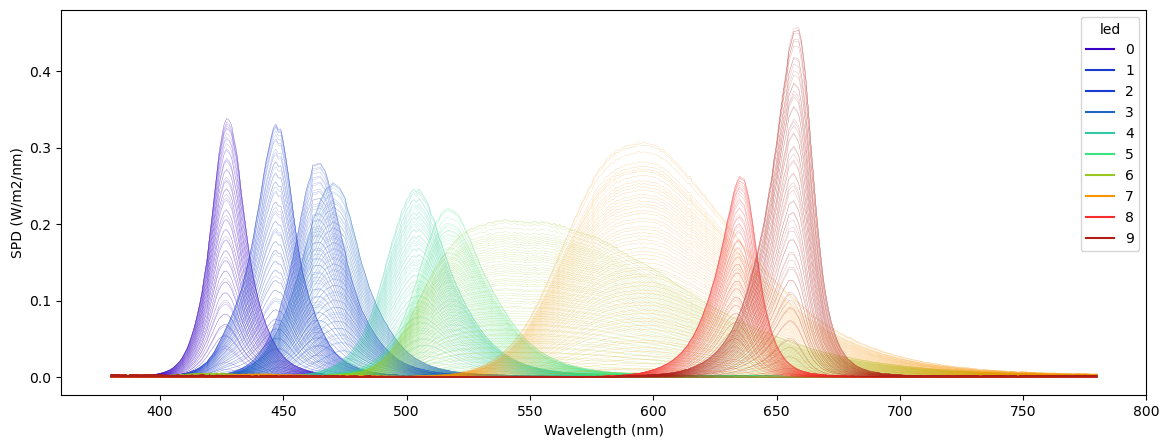

In [3]:
# from pyplr.calibrate import CalibrationContext as calibrationContext
# Calibration - important
import pyplr.calibrate as calb
from importlib import reload
reload(calb)
# file type to be read must be in format of:
# led | intensity | wavelength 1 (380) | wavelength 2 | ... | wavelength n (780)

cc = calb.CalibrationContext(
    'S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()


In [4]:
# calculate the peak spectral sensitivity for each LED at its maximum intensity setting
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

led
0    427
1    447
2    465
3    470
4    505
5    517
6    540
7    594
8    635
9    659
dtype: int64

In [5]:
blue_led = 3
red_led = 9
target_lux = 800

# Find the required intensity setting of the blue led for 800 lux
blue_intensity = (cc.lux.loc[blue_led].sub(target_lux)
                                      .abs()
                                      .idxmin())
#                                     .values[0])

# Find the intensity setting of the red led for 800 lux
red_intensity = cc.match(match_led=blue_led,
                         match_led_intensity=blue_intensity,
                         target_led=red_led,
                         match_type='irrad')[1]

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\CIE.py:5908: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  sss.index = pd.Int64Index(sss.index)


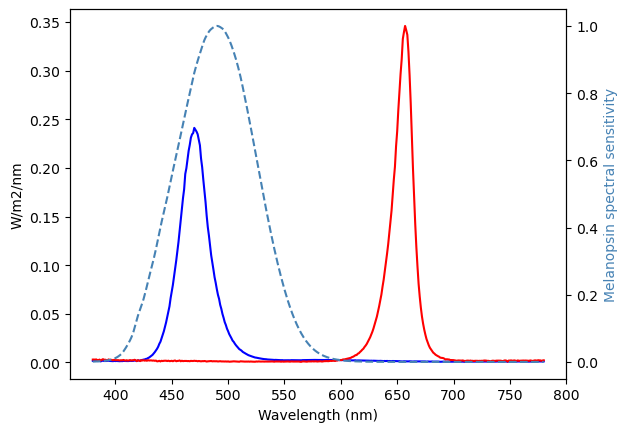

In [6]:
import matplotlib.pyplot as plt
from pyplr.CIE import get_CIES026

fig, ax = plt.subplots()
sss = get_CIES026(binwidth=1)
ax.plot(cc.lkp.loc[(blue_led, blue_intensity)], c='blue')
ax.plot(cc.lkp.loc[(red_led, red_intensity)], c='red')

ax2 = ax.twinx()
ax2.plot(sss['I'], ls='dashed', c='steelblue') # melanopsin = "I"
ax2.set_ylabel('Melanopsin spectral sensitivity', c='steelblue')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('W/m2/nm');

In [7]:
from pyplr import stlab

blue_spec, red_spec = [0]*10, [0]*10
blue_spec[blue_led] = blue_intensity
red_spec[red_led] = red_intensity
d.turn_off()

<Response [200]>

In [8]:
from time import sleep
# import random # not using this library unless we want to randomize stims
from pyplr.pupil import PupilCore
from pyplr.utils import unpack_data_pandas
from pyplr.protocol import input_subject_id, subject_dir
# Connect to Pupil Core
p = PupilCore()
p.check_3d_model()

> Refit the 3d model? [y/n]: n


Please enter subject ID: 888
> Grabbing 540 seconds of pupil.1.3d
> Grabbing 540 seconds of pupil.0.3d
> Waiting for a light to stamp...
> Light stamped on frame.world at 502524.537081
> Waiting for a light to stamp...
> Light stamped on frame.world at 502615.971327
> Waiting for a light to stamp...
> Light stamped on frame.world at 502707.506055
> Waiting for a light to stamp...
> Light stamped on frame.world at 502798.897673
> Waiting for a light to stamp...
> Light stamped on frame.world at 502890.421274
> Waiting for a light to stamp...
> Light stamped on frame.world at 502982.026509
> PupilGrabber done grabbing 540 seconds of pupil.1.3d
> PupilGrabber done grabbing 540 seconds of pupil.0.3d


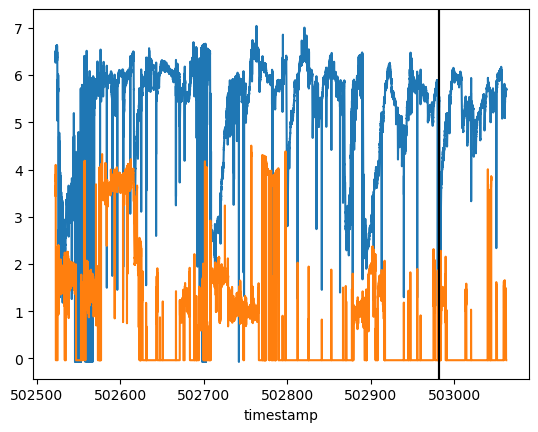

In [9]:
# PIPR STIMS - USE THIS ONE
d.turn_off()
subject_id = input_subject_id()
subj_dir = subject_dir(subject_id)
sleep(2)
ISI = 85 # interstimulus time (seconds) = this variable + 5s due to sleep + processing
num_trials = 6 # total number of trials
run_time = ISI*num_trials + 5*num_trials + 30# appropriate offset to account for stim duration + sleeps (removed + 30)


# Start a new recording called "my_recording"
p.command('R my_recording')

# Wait a few seconds
sleep(2)

# Make an annotation for when the light comes on
annotation = p.new_annotation('LIGHT_ON')

# Start the .light_stamper(...) and .pupil_grabber(...)
# this only captures one eye
# pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=25) # time here is TOTAL run time
pgr_future_eye1 = p.pupil_grabber(topic='pupil.1.3d', seconds=run_time) # time here is TOTAL run time
pgr_future_eye0 = p.pupil_grabber(topic='pupil.0.3d', seconds=run_time) # time here is TOTAL run time

sleep(2)
##################################
# Administer light stimulus here #
led_list = [3,9]*3
# random.shuffle(led_list) # use this if stims should be randomized
for led in led_list:
    intensities = [0]*10
    if led == 3:
        intensities[led] = int(blue_intensity)
    else:
        intensities[led] = int(red_intensity)
    lst_future = p.light_stamper(annotation=annotation, timeout=10)
    d.set_spectrum_a(intensities)
    sleep(1.)
    d.turn_off()
    sleep(ISI)
    sleep(5) # make sure there is extra time so that trials do not overlap
##################################

# Wait for the futures
while lst_future.running() or pgr_future_eye0.running() or pgr_future_eye1.running():
    print('Waiting for futures...')
    sleep(1)

# End recording
p.command('r')

# Get the timestamp and pupil data
timestamp = lst_future.result()[1]
data_eye0 = unpack_data_pandas(pgr_future_eye0.result())
data_eye1 = unpack_data_pandas(pgr_future_eye1.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax_0 = data_eye0['diameter_3d'].plot()
ax_0.axvline(x=timestamp, color='k')
ax_1 = data_eye1['diameter_3d'].plot()
ax_1.axvline(x=timestamp, color='k')

In [10]:
# display data from pandas table
data_eye0

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
502522.461494,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.49084191123378496, 0.20494398199634878]",57.897114,0.716502,"{'center': [8.0766530283359, 6.935579539986856...","{'center': [150.02630259459352, 142.4408873413...","{'center': [0.28745586327328443, 6.93498687076...",6.302442,"{'center': [94.24164695688671, 152.65075545670...","[94.24164695688671, 152.65075545670103]",1.0,1.570853,-2.418127
502522.495214,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.4909146546997833, 0.2049320797798707]",58.035878,0.789961,"{'center': [8.0766530283359, 6.935579539986856...","{'center': [150.02630259459352, 142.4408873413...","{'center': [0.2882251462760772, 6.934766566540...",6.318450,"{'center': [94.25561370235839, 152.65304068226...","[94.25561370235839, 152.65304068226482]",1.0,1.570875,-2.418015
502522.521080,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.49152257313813513, 0.20581665940776395]",58.058421,0.747645,"{'center': [8.0766530283359, 6.935579539986856...","{'center': [150.02630259459352, 142.4408873413...","{'center': [0.3003904401470976, 6.912706573319...",6.320501,"{'center': [94.37233404252194, 152.48320139370...","[94.37233404252194, 152.48320139370932]",1.0,1.572997,-2.416251
502522.544660,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.49090871077502335, 0.20516309069859728]",58.048190,0.778511,"{'center': [8.0766530283359, 6.935579539986856...","{'center': [150.02630259459352, 142.4408873413...","{'center': [0.28802180935888533, 6.92969653074...",6.320169,"{'center': [94.25447246880448, 152.60868658586...","[94.25447246880448, 152.60868658586932]",1.0,1.571362,-2.418045
502522.569125,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.4916545808323958, 0.20671928021489572]",58.384512,0.806150,"{'center': [8.0766530283359, 6.935579539986856...","{'center': [150.02630259459352, 142.4408873413...","{'center': [0.30131016891785833, 6.89190838839...",6.359342,"{'center': [94.39767951982, 152.30989819874003...","[94.39767951982, 152.30989819874003]",1.0,1.574999,-2.416125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503062.396553,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.4994415544254143, 0.16805957517286585]",53.037018,0.931313,"{'center': [8.0766530283359, 6.935579539986856...","{'center': [150.02630259459352, 142.4408873413...","{'center': [0.4899309500607778, 7.719599776612...",5.687607,"{'center': [95.89277844967955, 159.73256156680...","[95.89277844967955, 159.73256156680975]",1.0,1.495282,-2.392224
503062.409365,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.4990744134116359, 0.1680739093257525]",53.269354,0.940366,"{'center': [8.0766530283359, 6.935579539986856...","{'center': [150.02630259459352, 142.4408873413...","{'center': [0.4815828142019454, 7.720686511806...",5.714731,"{'center': [95.8222873750341, 159.729809409455...","[95.8222873750341, 159.72980940945553]",1.0,1.495177,-2.393416
503062.419337,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.4992497450179631, 0.16804328968521054]",53.239289,0.909929,"{'center': [8.0766530283359, 6.935579539986856...","{'center': [150.02630259459352, 142.4408873413...","{'center': [0.4852595779461204, 7.720615297367...",5.710899,"{'center': [95.85595104344891, 159.73568838043...","[95.85595104344891, 159.73568838043957]",1.0,1.495184,-2.392894


In [11]:
data_eye1

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
502522.422451,1,pupil.1.3d,pye3d 0.3.0 real-time,"[1.0528966866961282, 0.6466192613793127]",61.212521,0.039875,"{'center': [3.8949409980149308, -3.60570723168...","{'center': [133.36640174083783, 61.31547748543...","{'center': [6.903610676467819, -1.931716921685...",3.631557,"{'center': [202.1561638456566, 67.849101815171...","[202.1561638456566, 67.84910181517198]",1.0,1.409012,-1.273078
502522.461160,1,pupil.1.3d,pye3d 0.3.0 real-time,"[1.0658144897041513, 0.6554932400188125]",59.321842,0.041292,"{'center': [3.8949409980149308, -3.60570723168...","{'center': [133.36640174083783, 61.31547748543...","{'center': [7.067329965209316, -2.044441439893...",3.522173,"{'center': [204.63638202319706, 66.14529791638...","[204.63638202319706, 66.14529791638799]",1.0,1.419993,-1.256899
502522.488403,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.9846629223301665, 0.5825508984596612]",61.486775,0.045823,"{'center': [3.8949409980149308, -3.60570723168...","{'center': [133.36640174083783, 61.31547748543...","{'center': [6.071836262227976, -1.146738019329...",3.642362,"{'center': [189.05528108739196, 80.15022749574...","[189.05528108739196, 80.15022749574506]",1.0,1.331916,-1.353496
502522.511440,1,pupil.1.3d,pye3d 0.3.0 real-time,"[1.1043572826516834, 0.6421238434183159]",57.577987,0.028875,"{'center': [3.8949409980149308, -3.60570723168...","{'center': [133.36640174083783, 61.31547748543...","{'center': [7.5977874607199665, -1.90480830887...",3.436627,"{'center': [212.0365982691232, 68.712222063683...","[212.0365982691232, 68.71222206368337]",1.0,1.406388,-1.201267
502522.541716,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.9881296317539254, 0.5810836526267775]",63.596671,0.031686,"{'center': [3.8949409980149308, -3.60570723168...","{'center': [133.36640174083783, 61.31547748543...","{'center': [6.117983622261304, -1.127771298614...",3.769720,"{'center': [189.72088929675368, 80.43193869565...","[189.72088929675368, 80.43193869565872]",1.0,1.330038,-1.348710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503062.333922,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.0, 1.0]",0.000000,0.000000,"{'center': [3.8949409980149308, -3.60570723168...","{'center': [133.36640174083783, 61.31547748543...","{'center': [4.2129611753879885, -3.89019241275...",-0.038056,"{'center': [0.0, 0.0], 'axes': [0.0, 0.0], 'an...","[0.0, 0.0]",0.1,1.598174,-1.540179
503062.356904,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.0, 1.0]",0.000000,0.000000,"{'center': [3.8949409980149308, -3.60570723168...","{'center': [133.36640174083783, 61.31547748543...","{'center': [4.2129611753879885, -3.89019241275...",-0.038056,"{'center': [0.0, 0.0], 'axes': [0.0, 0.0], 'an...","[0.0, 0.0]",0.1,1.598174,-1.540179
503062.373044,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.0, 1.0]",0.000000,0.000000,"{'center': [3.8949409980149308, -3.60570723168...","{'center': [133.36640174083783, 61.31547748543...","{'center': [4.2129611753879885, -3.89019241275...",-0.038056,"{'center': [0.0, 0.0], 'axes': [0.0, 0.0], 'an...","[0.0, 0.0]",0.1,1.598174,-1.540179


In [12]:
import os  

# os.makedirs('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata', exist_ok=True) 

data_eye0.to_csv(path_base + subj_base + '-eye0.csv')
data_eye1.to_csv(path_base + subj_base + '-eye1.csv')

**DATA PROCESSING BEGINS BELOW - note the light turned on between trial 4/5**

In [13]:
samples_eye0 = data_eye0
samples_eye1 = data_eye1

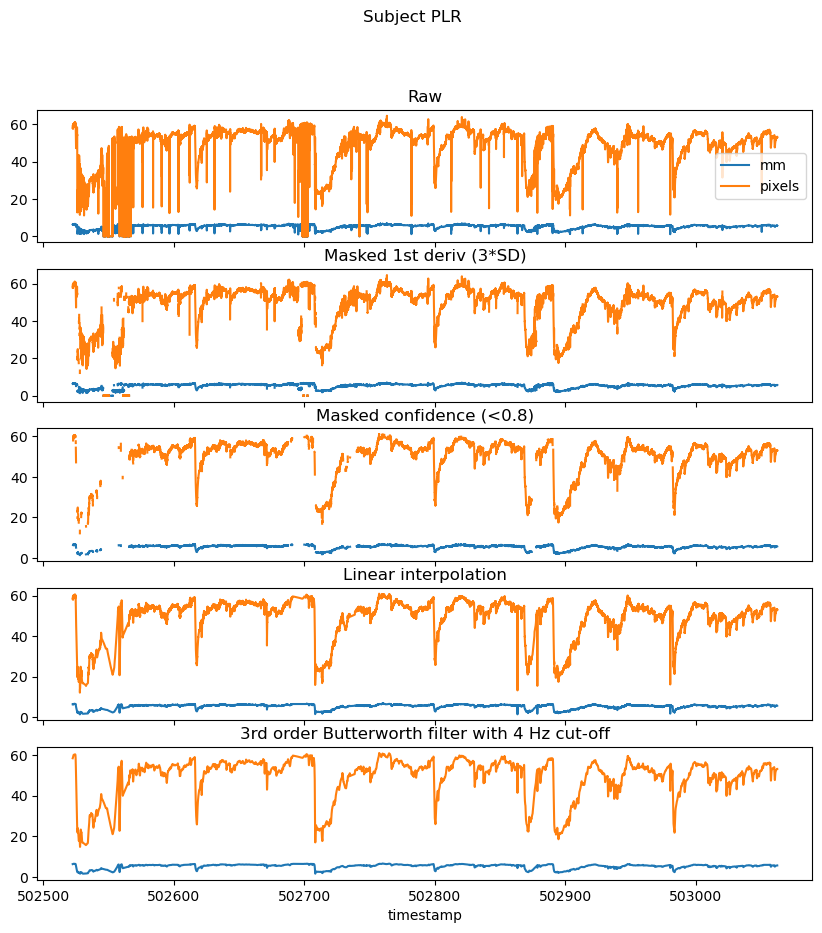

In [14]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye0[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye0 = preproc.mask_pupil_first_derivative(
    samples_eye0, threshold=3.0, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye0 = preproc.mask_pupil_confidence(
    samples_eye0, threshold=0.8, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye0 = preproc.interpolate_pupil(
    samples_eye0, interp_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye0 = preproc.butterworth_series(
    samples_eye0, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye0[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [15]:
# export butterworth processed sample data for eye 0
samples_eye0.to_csv(path_base + subj_base + '-butterworth-eye0.csv') # raw data

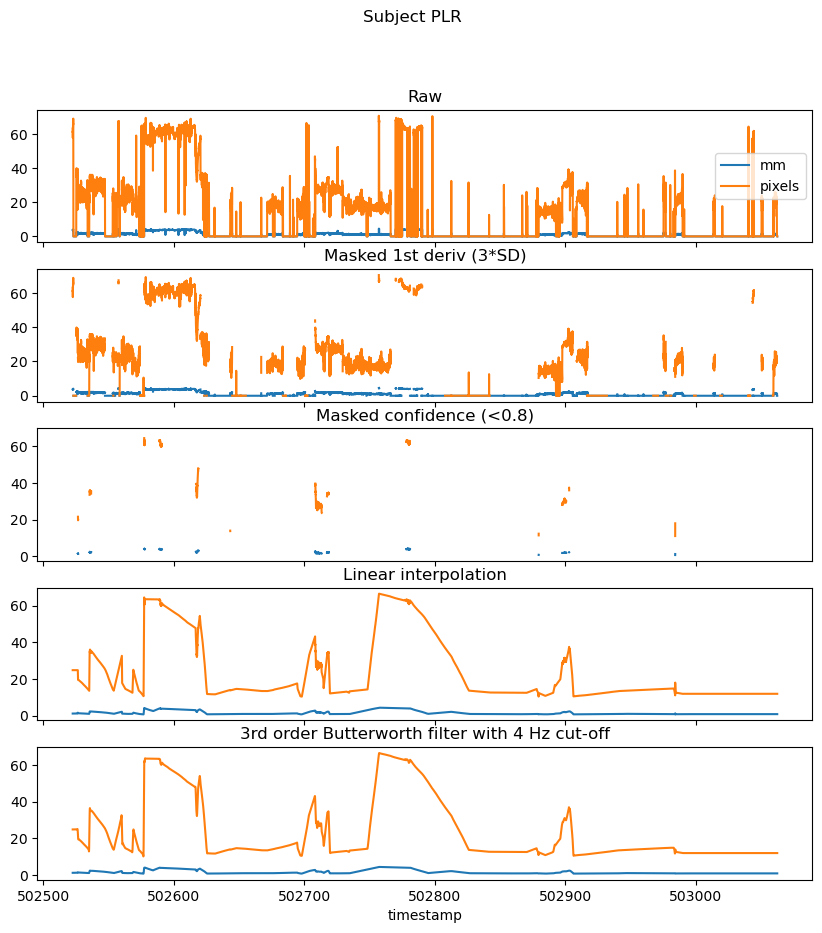

In [16]:
# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye1[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye1 = preproc.mask_pupil_first_derivative(
    samples_eye1, threshold=3.0, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye1 = preproc.mask_pupil_confidence(
    samples_eye1, threshold=0.8, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye1 = preproc.interpolate_pupil(
    samples_eye1, interp_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye1 = preproc.butterworth_series(
    samples_eye1, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye1[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [17]:
# export butterworth processed sample data for eye 1
samples_eye1.to_csv(path_base + subj_base + '-butterworth-eye1.csv') # raw data
# can stop here if necessary

**CAN STOP HERE AND DO ANALYSIS LATER**

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [19]:
# df_pipr = pd.read_csv("C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/sub-999_ses-02_dat-20230419.csv")
df_pipr_eye0 = pd.read_csv(path_base + subj_base + '-eye0.csv')
df_pipr_eye1 = pd.read_csv(path_base + subj_base + '-eye1.csv')

# Print header names
# print(df_pipr.columns)

# Extract the column with header "timestamp"
timestamps_eye0 = df_pipr_eye0["timestamp"]
timestamps_eye1 = df_pipr_eye1["timestamp"]
# Extract the column with header "diameter_3d"
diam_3d_eye0 = df_pipr_eye0["diameter_3d"]
diam_3d_eye1 = df_pipr_eye1["diameter_3d"]

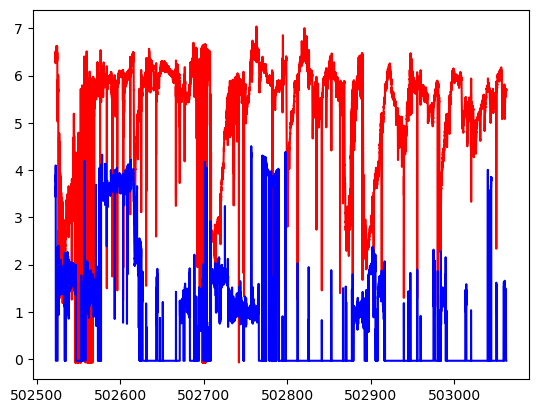

In [20]:
fig = plt.figure()
# plot eye0 in red, eye1 in blue
plt.plot(timestamps_eye0, diam_3d_eye0, 'r') # this should be the smoothed out data - if not, check
plt.plot(timestamps_eye1, diam_3d_eye1, 'b') # this should be the smoothed out data - if not, check

This is copied from the output of cell 11
> Light stamped on frame.world at 502524.537081
> Waiting for a light to stamp...
> Light stamped on frame.world at 502615.971327
> Waiting for a light to stamp...
> Light stamped on frame.world at 502707.506055
> Waiting for a light to stamp...
> Light stamped on frame.world at 502798.897673
> Waiting for a light to stamp...
> Light stamped on frame.world at 502890.421274
> Waiting for a light to stamp...
> Light stamped on frame.world at 502982.026509

**Edit Cell Below with Timestamps**

In [32]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps_eye1 <= 502524.537081)[0][-1]
stamp2 = np.where(timestamps_eye1 <= 502615.971327)[0][-1]
stamp3 = np.where(timestamps_eye1 <= 502707.506055)[0][-1]
stamp4 = np.where(timestamps_eye1 <= 502798.897673)[0][-1]
stamp5 = np.where(timestamps_eye1 <= 502890.421274)[0][-1]
stamp6 = np.where(timestamps_eye1 <= 502982.026509)[0][-1]
stamps = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps

[88, 3842, 9566, 14428, 20883, 26999]

In [22]:
from pyplr import utils
from copy import deepcopy

In [23]:
df_data_eye0 = df_pipr_eye0[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1 = df_pipr_eye1[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1

,timestamp,confidence,id,diameter,diameter_3d
0,502522.422451,0.039875,1,61.212521,3.631557
1,502522.461160,0.041292,1,59.321842,3.522173
2,502522.488403,0.045823,1,61.486775,3.642362
3,502522.511440,0.028875,1,57.577987,3.436627
4,502522.541716,0.031686,1,63.596671,3.769720
...,...,...,...,...,...
31464,503062.333922,0.000000,1,0.000000,-0.038056
31465,503062.356904,0.000000,1,0.000000,-0.038056
31466,503062.373044,0.000000,1,0.000000,-0.038056
31467,503062.390050,0.000000,1,0.000000,-0.038056


**Extract ranges from samples based on event timing and sample count**

Adapted from extract() from utils.py. Set variables - change as necessary. 
Note: even though ISI is 120, we only want 60s of post measurement

In [33]:
samples_eye0 = df_data_eye0
samples_eye1 = df_data_eye1
event_starts = stamps 
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs = (
    np.searchsorted(samples_eye0.index, event_starts, "left") + offset
)
range_duration = duration


In [25]:
range_idxs

array([   27,  6802, 14372, 22323, 30197, 37988], dtype=int64)

In [26]:
# make a hierarchical index for eye 0
samples_eye0["orig_idx"] = samples_eye0.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye0 = pd.DataFrame()
idx = 0
for start_idx in range_idxs:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye0):
        end_idx = len(samples_eye0) - 1
    new_df_eye0 = deepcopy(
        samples_eye0.loc[samples_eye0.index[start_idx] : samples_eye0.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye0 = pd.concat([df_eye0, new_df_eye0])
    idx += 1
df_eye0.index = midx
print("Extracted ranges for {} events".format(len(event_starts)))

Extracted ranges for 6 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_20572\34663238.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_eye0["orig_idx"] = samples_eye0.index


In [27]:
df_eye0.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

In [34]:
# make a hierarchical index for eye 1
samples_eye1["orig_idx"] = samples_eye1.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye1 = pd.DataFrame()
idx = 0
for start_idx in range_idxs:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye1):
        end_idx = len(samples_eye1) - 1
    new_df_eye1 = deepcopy(
        samples_eye1.loc[samples_eye1.index[start_idx] : samples_eye1.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye1 = pd.concat([df_eye1, new_df_eye1])
    idx += 1
df_eye1.index = midx
print("Extracted ranges for {} events".format(len(event_starts)))

Extracted ranges for 6 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_20572\1824459667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_eye1["orig_idx"] = samples_eye1.index


In [35]:
df_eye1.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

**Re-run the processing on the multi-index data, eye 0**

In [36]:
from pyplr import graphing
from pyplr import preproc
# Calculate baselines
baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye0 = preproc.percent_signal_change(
    df_eye0, baselines_eye0, ['diameter_3d', 'diameter'])
df_eye0

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_20572\4183176285.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      502523.061493    0.829111   0  59.502197     6.454618        27   
      1      502523.082309    0.911566   0  60.146153     6.532031        28   
      2      502523.089981    0.780443   0  59.291811     6.430158        29   
      3      502523.111416    0.769851   0  59.197876     6.419511        30   
      4      502523.131831    0.801356   0  59.919806     6.505394        31   
...                    ...         ...  ..        ...          ...       ...   
5     3595   503028.347975    1.000000   0  47.538079     5.120090     41583   
      3596   503028.365802    1.000000   0  47.485093     5.115840     41584   
      3597   503028.375598    1.000000   0  47.417300     5.109294     41585   
      3598   503028.389017    1.000000   0  47.486311     5.116757     41586   
      3599   503028.400304    1.000000   0  47.443552     5.111578     41587   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           -0.635493    -0.673964  
      1            0.556214     0.400981  
      2           -1.012042    -1.025157  
      3           -1.175947    -1.181963  
      4            0.146160     0.023143  
...                     ...          ...  
5     3595        -2.333626    -3.966618  
      3596        -2.414703    -4.073657  
      3597        -2.539568    -4.210609  
      3598        -2.397202    -4.071197  
      3599        -2.495986    -4.157575  

[21600 rows x 8 columns]

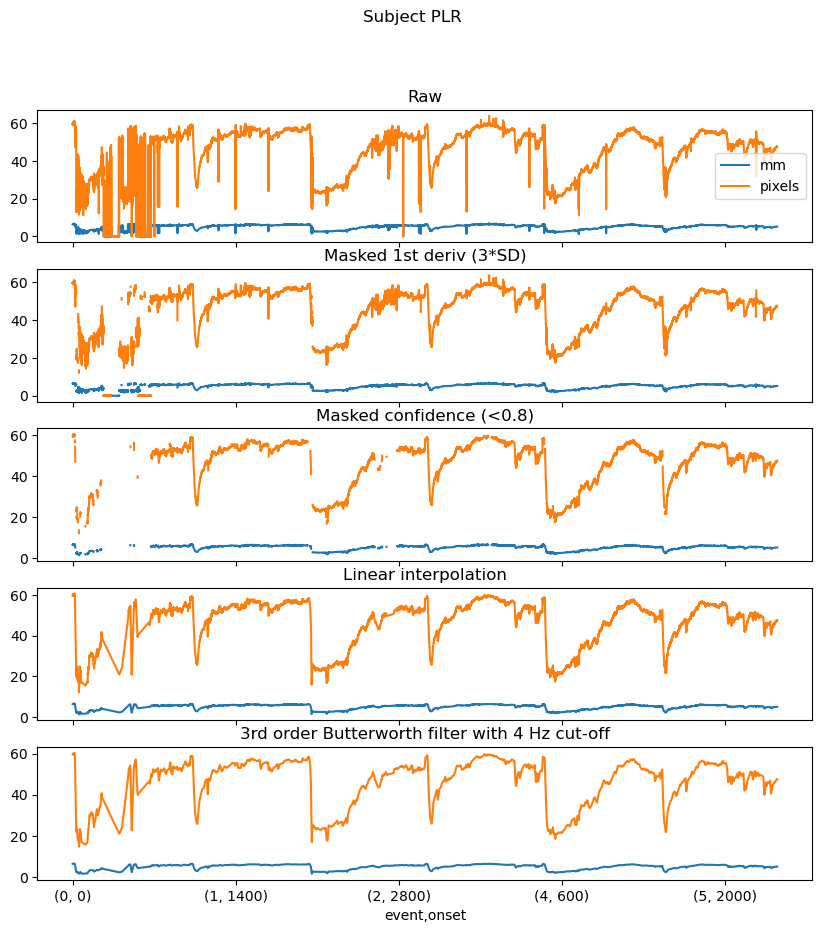

In [37]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120
samples_eye0 = df_eye0

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye0[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye0 = preproc.mask_pupil_first_derivative(
    samples_eye0, threshold=3.0, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye0 = preproc.mask_pupil_confidence(
    samples_eye0, threshold=0.8, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye0 = preproc.interpolate_pupil(
    samples_eye0, interp_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye0 = preproc.butterworth_series(
    samples_eye0, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye0[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [38]:
samples_eye0 # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      502523.061493    0.829111   0  59.512101     6.455701        27   
      1      502523.082309    0.911566   0  59.583038     6.464491        28   
      2      502523.089981    0.780443   0  59.652300     6.473074        29   
      3      502523.111416    0.769851   0  59.718567     6.481292        30   
      4      502523.131831    0.801356   0  59.780665     6.489002        31   
...                    ...         ...  ..        ...          ...       ...   
5     3595   503028.347975    1.000000   0  47.521336     5.119346     41583   
      3596   503028.365802    1.000000   0  47.510078     5.118331     41584   
      3597   503028.375598    1.000000   0  47.498161     5.117228     41585   
      3598   503028.389017    1.000000   0  47.486063     5.116087     41586   
      3599   503028.400304    1.000000   0  47.474230     5.114957     41587   

             diameter_3d_pc  diameter_pc  interpolated  
event onset                                             
0     0           -0.635493    -0.673964             0  
      1            0.556214     0.400981             0  
      2           -1.012042    -1.025157             1  
      3           -1.175947    -1.181963             1  
      4            0.146160     0.023143             0  
...                     ...          ...           ...  
5     3595        -2.333626    -3.966618             0  
      3596        -2.414703    -4.073657             0  
      3597        -2.539568    -4.210609             0  
      3598        -2.397202    -4.071197             0  
      3599        -2.495986    -4.157575             0  

[21600 rows x 9 columns]

In [39]:
df_eye0

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      502523.061493    0.829111   0  59.502197     6.454618        27   
      1      502523.082309    0.911566   0  60.146153     6.532031        28   
      2      502523.089981    0.780443   0  59.291811     6.430158        29   
      3      502523.111416    0.769851   0  59.197876     6.419511        30   
      4      502523.131831    0.801356   0  59.919806     6.505394        31   
...                    ...         ...  ..        ...          ...       ...   
5     3595   503028.347975    1.000000   0  47.538079     5.120090     41583   
      3596   503028.365802    1.000000   0  47.485093     5.115840     41584   
      3597   503028.375598    1.000000   0  47.417300     5.109294     41585   
      3598   503028.389017    1.000000   0  47.486311     5.116757     41586   
      3599   503028.400304    1.000000   0  47.443552     5.111578     41587   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           -0.635493    -0.673964  
      1            0.556214     0.400981  
      2           -1.012042    -1.025157  
      3           -1.175947    -1.181963  
      4            0.146160     0.023143  
...                     ...          ...  
5     3595        -2.333626    -3.966618  
      3596        -2.414703    -4.073657  
      3597        -2.539568    -4.210609  
      3598        -2.397202    -4.071197  
      3599        -2.495986    -4.157575  

[21600 rows x 8 columns]

In [40]:
# Calculate baselines
baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye0 = preproc.percent_signal_change(
    df_eye0, baselines_eye0, ['diameter_3d', 'diameter'])
df_eye0

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_20572\2547890342.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      502523.061493    0.829111   0  59.502197     6.454618        27   
      1      502523.082309    0.911566   0  60.146153     6.532031        28   
      2      502523.089981    0.780443   0  59.291811     6.430158        29   
      3      502523.111416    0.769851   0  59.197876     6.419511        30   
      4      502523.131831    0.801356   0  59.919806     6.505394        31   
...                    ...         ...  ..        ...          ...       ...   
5     3595   503028.347975    1.000000   0  47.538079     5.120090     41583   
      3596   503028.365802    1.000000   0  47.485093     5.115840     41584   
      3597   503028.375598    1.000000   0  47.417300     5.109294     41585   
      3598   503028.389017    1.000000   0  47.486311     5.116757     41586   
      3599   503028.400304    1.000000   0  47.443552     5.111578     41587   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           -0.635493    -0.673964  
      1            0.556214     0.400981  
      2           -1.012042    -1.025157  
      3           -1.175947    -1.181963  
      4            0.146160     0.023143  
...                     ...          ...  
5     3595        -2.333626    -3.966618  
      3596        -2.414703    -4.073657  
      3597        -2.539568    -4.210609  
      3598        -2.397202    -4.071197  
      3599        -2.495986    -4.157575  

[21600 rows x 8 columns]

**Re-run processing on multi-index data, eye 1**

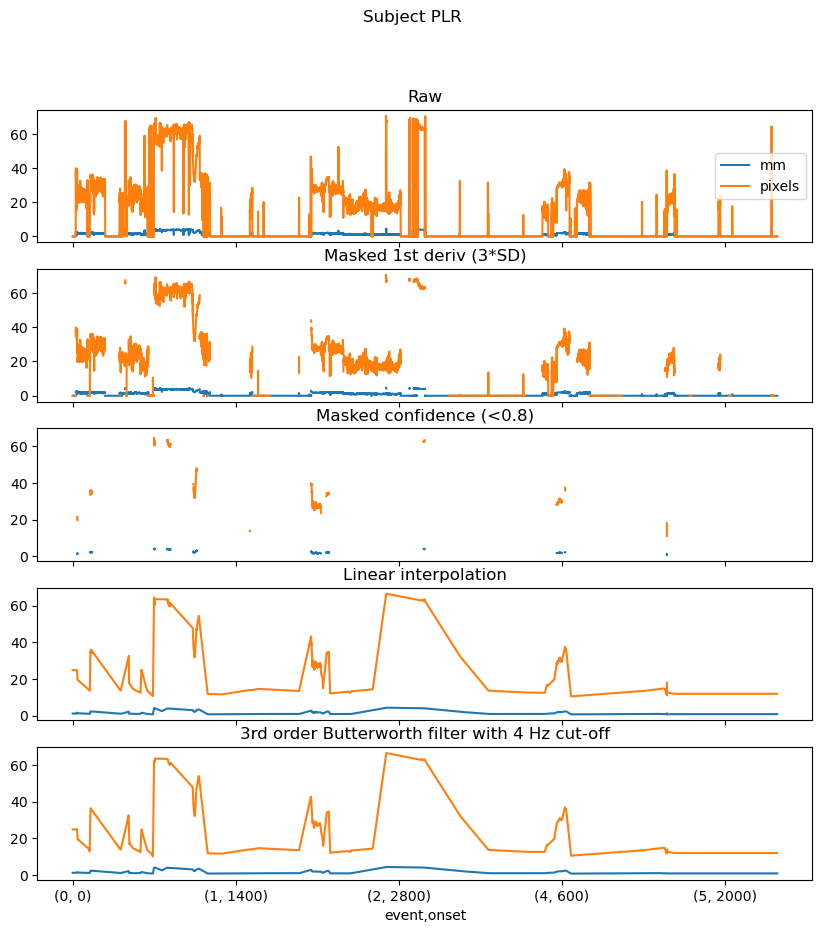

In [41]:
# Sampling frequency
SAMPLE_RATE = 120
samples_eye1 = df_eye1

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye1[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye1 = preproc.mask_pupil_first_derivative(
    samples_eye1, threshold=3.0, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye1 = preproc.mask_pupil_confidence(
    samples_eye1, threshold=0.8, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye1 = preproc.interpolate_pupil(
    samples_eye1, interp_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye1 = preproc.butterworth_series(
    samples_eye1, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye1[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [42]:
samples_eye1 # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      502523.165021         0.0   1  24.779240     1.077374        28   
      1      502523.186021         0.0   1  24.779240     1.077374        29   
      2      502523.208859         0.0   1  24.779240     1.077374        30   
      3      502523.235114         0.0   1  24.779240     1.077374        31   
      4      502523.261152         0.0   1  24.779240     1.077374        32   
...                    ...         ...  ..        ...          ...       ...   
5     3595   503043.204887         0.0   1  11.866082     0.759679     30534   
      3596   503043.224655         0.0   1  11.866082     0.759679     30535   
      3597   503043.248236         0.0   1  11.866082     0.759679     30536   
      3598   503043.267002         0.0   1  11.866082     0.759679     30537   
      3599   503043.281681         0.0   1  11.866082     0.759679     30538   

             interpolated  
event onset                
0     0                 1  
      1                 1  
      2                 1  
      3                 1  
      4                 1  
...                   ...  
5     3595              1  
      3596              1  
      3597              1  
      3598              1  
      3599              1  

[21600 rows x 7 columns]

In [43]:
df_eye1

timestamp  confidence  id  diameter  diameter_3d  orig_idx
event onset                                                                
0     0      502523.165021         0.0   1  0.000005    -0.038056        28
      1      502523.186021         0.0   1  0.000005    -0.038056        29
      2      502523.208859         0.0   1  0.000005    -0.038056        30
      3      502523.235114         0.0   1  0.000005    -0.038056        31
      4      502523.261152         0.0   1  0.000005    -0.038056        32
...                    ...         ...  ..       ...          ...       ...
5     3595   503043.204887         0.0   1  0.000000    -0.038056     30534
      3596   503043.224655         0.0   1  0.000000    -0.038056     30535
      3597   503043.248236         0.0   1  0.000000    -0.038056     30536
      3598   503043.267002         0.0   1  0.000000    -0.038056     30537
      3599   503043.281681         0.0   1  0.000000    -0.038056     30538

[21600 rows x 6 columns]

In [62]:
# Calculate baselines
baselines_eye1 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye1 = preproc.percent_signal_change(
    df_eye1, baselines_eye1, ['diameter_3d', 'diameter'])
df_eye1

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_20572\3109839274.py:2: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  baselines_eye1 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_20572\3109839274.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye1 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_20572\3109839274.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError 

timestamp  confidence  id  diameter  diameter_3d  \
event onset                                                              
0     -1.000000   502523.165021         0.0   1  0.000005    -0.038056   
      -0.983333   502523.186021         0.0   1  0.000005    -0.038056   
      -0.966667   502523.208859         0.0   1  0.000005    -0.038056   
      -0.950000   502523.235114         0.0   1  0.000005    -0.038056   
      -0.933333   502523.261152         0.0   1  0.000005    -0.038056   
...                         ...         ...  ..       ...          ...   
5      58.916667  503043.204887         0.0   1  0.000000    -0.038056   
       58.933333  503043.224655         0.0   1  0.000000    -0.038056   
       58.950000  503043.248236         0.0   1  0.000000    -0.038056   
       58.966667  503043.267002         0.0   1  0.000000    -0.038056   
       58.983333  503043.281681         0.0   1  0.000000    -0.038056   

                  orig_idx colour  diameter_3d_pc  diameter_pc  
event onset                                                     
0     -1.000000         28   blue     -101.103156   -99.999983  
      -0.983333         29   blue     -101.103156   -99.999983  
      -0.966667         30   blue     -101.103156   -99.999983  
      -0.950000         31   blue     -101.103156   -99.999983  
      -0.933333         32   blue     -101.103156   -99.999983  
...                    ...    ...             ...          ...  
5      58.916667     30534    red     -100.737275  -100.000000  
       58.933333     30535    red     -100.737275  -100.000000  
       58.950000     30536    red     -100.737275  -100.000000  
       58.966667     30537    red     -100.737275  -100.000000  
       58.983333     30538    red     -100.737275  -100.000000  

[21600 rows x 9 columns]

**Convert the index-level samples to time (s)**:

In [44]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df_eye0.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df_eye0.index = df_eye0.index.set_levels(
    levels=new_onset, level='onset')

In [45]:
df_eye0["colour"] = ""

In [46]:
for (event, onset) in df_eye0.index:
    if event%2==1:
        df_eye0["colour"][event,onset] = "red"
    else:
        df_eye0["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_20572\1670583221.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye0["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_20572\1670583221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye0["colour"][event,onset] = "red"


In [47]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df_eye1.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df_eye1.index = df_eye1.index.set_levels(
    levels=new_onset, level='onset')

In [48]:
df_eye1["colour"] = ""

In [49]:
for (event, onset) in df_eye1.index:
    if event%2==1:
        df_eye1["colour"][event,onset] = "red"
    else:
        df_eye1["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_20572\2599913087.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye1["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_20572\2599913087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye1["colour"][event,onset] = "red"


**Plot the PIPR:**

Text(0.5, 1.0, 'Eye = 0')

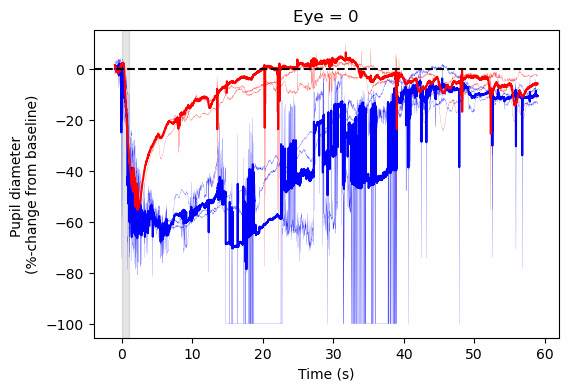

In [52]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df_eye0.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs_eye0 = (df_eye0.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs_eye0, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Eye = {}'.format(df_eye0['id'][0][0]))

In [53]:
import os
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + subj_base + '-eye0.png')

In [54]:
df_eye0 # check all is as expected before sending to csv

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                               
0     -1.000000   502523.061493    0.829111   0  59.502197     6.454618   
      -0.983333   502523.082309    0.911566   0  60.146153     6.532031   
      -0.966667   502523.089981    0.780443   0  59.291811     6.430158   
      -0.950000   502523.111416    0.769851   0  59.197876     6.419511   
      -0.933333   502523.131831    0.801356   0  59.919806     6.505394   
...                         ...         ...  ..        ...          ...   
5      58.916667  503028.347975    1.000000   0  47.538079     5.120090   
       58.933333  503028.365802    1.000000   0  47.485093     5.115840   
       58.950000  503028.375598    1.000000   0  47.417300     5.109294   
       58.966667  503028.389017    1.000000   0  47.486311     5.116757   
       58.983333  503028.400304    1.000000   0  47.443552     5.111578   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000         27       -0.635493    -0.673964   blue  
      -0.983333         28        0.556214     0.400981   blue  
      -0.966667         29       -1.012042    -1.025157   blue  
      -0.950000         30       -1.175947    -1.181963   blue  
      -0.933333         31        0.146160     0.023143   blue  
...                    ...             ...          ...    ...  
5      58.916667     41583       -2.333626    -3.966618    red  
       58.933333     41584       -2.414703    -4.073657    red  
       58.950000     41585       -2.539568    -4.210609    red  
       58.966667     41586       -2.397202    -4.071197    red  
       58.983333     41587       -2.495986    -4.157575    red  

[21600 rows x 9 columns]

In [55]:
df_eye0.to_csv(path_base + subj_base + '-processed-eye0.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

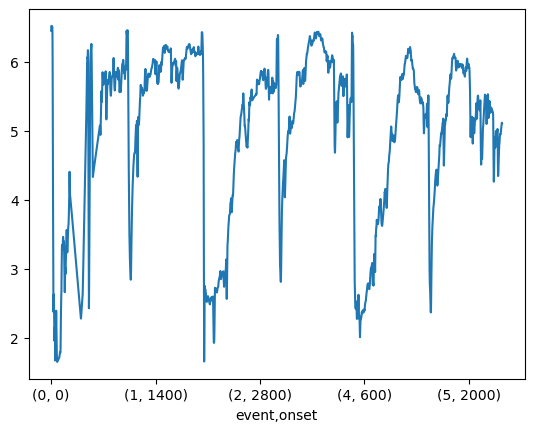

In [56]:
samples_eye0["diameter_3d"].plot()

In [57]:
avgs_eye0.to_csv(path_base + subj_base + '-average-pipr-eye0.csv') # processed data with adjusted onset indices (time in seconds)

Text(0.5, 1.0, 'Eye = 1')

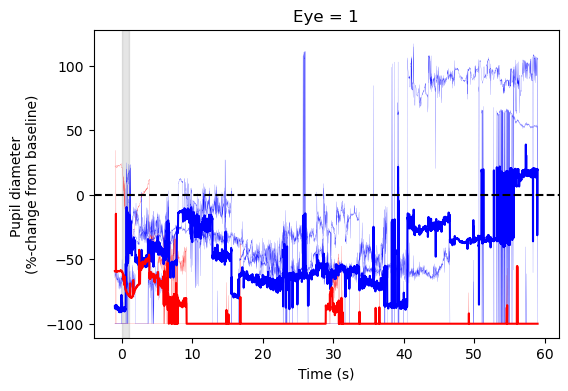

In [63]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df_eye1.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs_eye1 = (df_eye1.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs_eye1, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Eye = {}'.format(df_eye1['id'][0][0]))

In [64]:
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + subj_base + '-eye1.png')

In [65]:
df_eye1 # check all is as expected before sending to csv

timestamp  confidence  id  diameter  diameter_3d  \
event onset                                                              
0     -1.000000   502523.165021         0.0   1  0.000005    -0.038056   
      -0.983333   502523.186021         0.0   1  0.000005    -0.038056   
      -0.966667   502523.208859         0.0   1  0.000005    -0.038056   
      -0.950000   502523.235114         0.0   1  0.000005    -0.038056   
      -0.933333   502523.261152         0.0   1  0.000005    -0.038056   
...                         ...         ...  ..       ...          ...   
5      58.916667  503043.204887         0.0   1  0.000000    -0.038056   
       58.933333  503043.224655         0.0   1  0.000000    -0.038056   
       58.950000  503043.248236         0.0   1  0.000000    -0.038056   
       58.966667  503043.267002         0.0   1  0.000000    -0.038056   
       58.983333  503043.281681         0.0   1  0.000000    -0.038056   

                  orig_idx colour  diameter_3d_pc  diameter_pc  
event onset                                                     
0     -1.000000         28   blue     -101.103156   -99.999983  
      -0.983333         29   blue     -101.103156   -99.999983  
      -0.966667         30   blue     -101.103156   -99.999983  
      -0.950000         31   blue     -101.103156   -99.999983  
      -0.933333         32   blue     -101.103156   -99.999983  
...                    ...    ...             ...          ...  
5      58.916667     30534    red     -100.737275  -100.000000  
       58.933333     30535    red     -100.737275  -100.000000  
       58.950000     30536    red     -100.737275  -100.000000  
       58.966667     30537    red     -100.737275  -100.000000  
       58.983333     30538    red     -100.737275  -100.000000  

[21600 rows x 9 columns]

In [66]:
df_eye1.to_csv(path_base + subj_base + '-processed-eye1.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

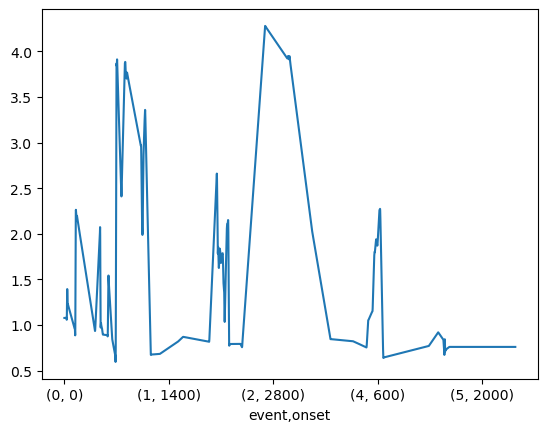

In [67]:
samples_eye1["diameter_3d"].plot()

In [68]:
avgs_eye1.to_csv(path_base + subj_base + '-average-pipr-eye1.csv') # processed data with adjusted onset indices (time in seconds)

**Compute the pupillary light response:**

In [ ]:
# adapt this to separate red and blue
from pyplr.plr import PLR

average_plr = df.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=60,
          onset_idx=-offset,
          stim_duration=1)

In [ ]:
fig = plr.plot(vel=True, acc=True, print_params=True)

In [ ]:
params = plr.parameters()
params

**Compute the PIPR:**

In [ ]:
# code to calculate PIPR at given time
pipr_time = 7 # measure PIPR at t=7s (6s after stimulus turned off)
print(avgs_eye0.loc[avgs_eye0["onset"] == pipr_time])
print(avgs_eye1.loc[avgs_eye1["onset"] == pipr_time])

In [70]:
# eye 0
blue_d_pipr_eye0 = avgs_eye0["diameter_3d"][480]
red_d_pipr_eye0 = avgs_eye0["diameter_3d"][4080]
blue_d_pipr_pc_eye0 = avgs_eye0["diameter_3d_pc"][480]
red_d_pipr_pc_eye0 = avgs_eye0["diameter_3d_pc"][4080]
pipr_diff_eye0 = red_d_pipr_eye0 - blue_d_pipr_eye0
pipr_pc_diff_eye0 = red_d_pipr_pc_eye0 - blue_d_pipr_pc_eye0
print("PIPR (Absolute Difference), Eye 0: ", pipr_diff_eye0)
print("PIPR (Percent Change), Eye 0: ", pipr_pc_diff_eye0)

PIPR (Absolute Difference), Eye 0:  2.1875020865181916
PIPR (Percent Change), Eye 0:  39.42263287597994


In [71]:
# eye 1
blue_d_pipr_eye1 = avgs_eye1["diameter_3d"][480]
red_d_pipr_eye1 = avgs_eye1["diameter_3d"][4080]
blue_d_pipr_pc_eye1 = avgs_eye1["diameter_3d_pc"][480]
red_d_pipr_pc_eye1 = avgs_eye1["diameter_3d_pc"][4080]
pipr_diff_eye1 = red_d_pipr_eye1 - blue_d_pipr_eye1
pipr_pc_diff_eye1 = red_d_pipr_pc_eye1 - blue_d_pipr_pc_eye1
print("PIPR (Absolute Difference), Eye 1: ", pipr_diff_eye1)
print("PIPR (Percent Change), Eye 1: ", pipr_pc_diff_eye1)

PIPR (Absolute Difference), Eye 1:  -1.1670044257717465
PIPR (Percent Change), Eye 1:  -26.11367293548446
